In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#combination of ALL the features

In [ ]:
import pandas as pd
import numpy as np
import spacy
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Further data Cleaning
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize words
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Stem words
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    return words

In [ ]:
# Load CSV dataset
data = pd.read_csv('/content/drive/MyDrive/dementia_data/5_combined_new.csv')

# Preprocess text (remove punctuation, lowercase, tokenize, etc.)
data["preprocessed_text"] = data["Sentence"].apply(preprocess_text)

In [ ]:
data.head()

,Sentence,Label,preprocessed_text
0,dogs horses um,0,"[dog, hors, um]"
1,yeah yeah bread,0,"[yeah, yeah, bread]"
2,uh flower fish xxx four did i say findq,0,"[uh, flower, fish, xxx, four, say, findq]"
3,well most anything anything to eat okay uh mel...,1,"[well, anyth, anyth, eat, okay, uh, melani, uh..."
4,uh hm food fire uh fence,0,"[uh, hm, food, fire, uh, fenc]"


In [ ]:
data.head()

,Sentence,Label,preprocessed_text,tokenized_text
0,dogs horses um,0,"[dog, hors, um]","[dogs, horses, um]"
1,yeah yeah bread,0,"[yeah, yeah, bread]","[yeah, yeah, bread]"
2,uh flower fish xxx four did i say findq,0,"[uh, flower, fish, xxx, four, say, findq]","[uh, flower, fish, xxx, four, did, i, say, findq]"
3,well most anything anything to eat okay uh mel...,1,"[well, anyth, anyth, eat, okay, uh, melani, uh...","[well, most, anything, anything, to, eat, okay..."
4,uh hm food fire uh fence,0,"[uh, hm, food, fire, uh, fenc]","[uh, hm, food, fire, uh, fence]"


In [ ]:
#Word Embeddings

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=data["preprocessed_text"], vector_size=100, window=5, min_count=1, sg=0)
# Assuming "preprocessed_text" column contains lists of tokens
X_word_embeddings = []
# Generate word vectors for speech segments
speech_vectors = []
for segment_text in data["preprocessed_text"]:
    word_vectors = [word2vec_model.wv[word] for word in segment_text if word in word2vec_model.wv]
    avg_vector = sum(word_vectors) / len(word_vectors) if word_vectors else [0.0] * 100
    speech_vectors.append(avg_vector)

# Obtain word embeddings and aggregate sentence embeddings
for tokens in data["preprocessed_text"]:
    embeddings = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if embeddings:
        sentence_embedding = sum(embeddings) / len(embeddings)
    else:
        sentence_embedding = [0.0] * word2vec_model.vector_size
    X_word_embeddings.append(sentence_embedding)

# Convert the list of embeddings to a NumPy array
X_word_embeddings = np.array(X_word_embeddings)

In [ ]:
#Sentence Embeddings

# Load Universal Sentence Encoder model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Encode sentences to obtain sentence embeddings
sentence_embeddings = embed(data["Sentence"])

X_sentence_embeddings = sentence_embeddings.numpy()

In [ ]:
# TF-IDF Vectorization with N-grams
tfidf_vectorizer = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(data["Sentence"]).toarray()

In [ ]:
# Word2Vec Variants
X_word2vec = []
for tokens in data["Sentence"]:
    embeddings = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if embeddings:
        sentence_embedding = sum(embeddings) / len(embeddings)
    else:
        sentence_embedding = [0.0] * word2vec_model.vector_size
    X_word2vec.append(sentence_embedding)

In [ ]:
# Load GloVe Embeddings (replace with your GloVe loading code)
glove_embeddings = {}  # Dictionary to store GloVe embeddings
glove_file_path = "/content/drive/MyDrive/dementia_data/glove.6B.100d.txt"  # Modify this path
with open(glove_file_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        glove_embeddings[word] = vector


# Word Embeddings using GloVe
X_glove = []
for tokens in data["Sentence"]:
    embeddings = [glove_embeddings.get(word, np.zeros(100)) for word in tokens]
    sentence_embedding = np.mean(embeddings, axis=0) if embeddings else np.zeros(100)
    X_glove.append(sentence_embedding)

In [ ]:
# Word Frequency and Document Length
word_frequency = [text.count("Label") for text in data["Sentence"]]  # Replace "target_word"
doc_lengths = [len(text.split()) for text in data["Sentence"]]
X_word_freq_doc_len = np.column_stack((word_frequency, doc_lengths))

In [ ]:
# Function to count hesitation words in a sentence
def count_hesitation_words(text):
    hesitation_count = len(re.findall(r'\b(uh|um|uh-huh|um-hum|mhm|huh)\b', text, flags=re.IGNORECASE))
    return hesitation_count
X_hesitation = [count_hesitation_words(sentence) for sentence in data["Sentence"]]
X_hesitation = np.array(X_hesitation).reshape(-1, 1)

In [ ]:
#Functions for all linguistic features
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Calculate Type Token Ratio (TTR) using preprocessed word lists
data['ttr'] = data['Sentence'].apply(lambda x: len(set(x)) / len(x))

vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
X = vectorizer.fit_transform(data['Sentence'])
total_words = X.sum(axis=1)
unique_words = (X > 0).sum(axis=1)
data['ttr'] = unique_words / total_words
def calculate_prepositional_ratio(text):
    doc = nlp(" ".join(text))
    total_words = len(doc)

    if total_words == 0:
        return 0.0

    num_prepositions = sum(1 for token in doc if token.pos_ == "ADP")
    prepositional_ratio = num_prepositions / total_words
    return prepositional_ratio

def calculate_verb_to_noun_ratio(text):
    doc = nlp(" ".join(text))
    total_words = len(doc)

    if total_words == 0:
        return 0.0

    num_verbs = sum(1 for token in doc if token.pos_ == "VERB")
    num_nouns = sum(1 for token in doc if token.pos_ == "NOUN")

    if num_nouns == 0:
        return 0.0

    verb_to_noun_ratio = num_verbs / num_nouns
    return verb_to_noun_ratio

def calculate_content_density(text):
    doc = nlp(" ".join(text))
    total_words = len(doc)

    if total_words == 0:
        return 0.0

    num_content_words = sum(1 for token in doc if token.pos_ in ["NOUN", "VERB", "ADJ", "ADV"])
    content_density = num_content_words / total_words
    return content_density

data['prepositional_ratio'] = data['preprocessed_text'].apply(calculate_prepositional_ratio)
data['verb_to_noun_ratio'] = data['preprocessed_text'].apply(calculate_verb_to_noun_ratio)
data['content_density'] = data['preprocessed_text'].apply(calculate_content_density)


# Calculate noun ratio and verb ratio
def calculate_pos_ratios(text):
    doc = nlp(" ".join(text))  # Join the list of preprocessed words into a single string
    total_words = len(doc)

    if total_words == 0:
        return 0.0, 0.0  # Return 0.0 for both ratios if there are no words

    num_nouns = sum(1 for token in doc if token.pos_ == "NOUN")
    num_verbs = sum(1 for token in doc if token.pos_ == "VERB")
    noun_ratio = num_nouns / total_words
    verb_ratio = num_verbs / total_words
    return noun_ratio, verb_ratio

data['noun_ratio'], data['verb_ratio'] = zip(*data['preprocessed_text'].apply(calculate_pos_ratios))

# Combine the results into the DataFrame
X_linguistic_features = data[['ttr', 'noun_ratio', 'verb_ratio', 'prepositional_ratio', 'content_density','verb_to_noun_ratio']].values


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# Combine features
X_combined = np.concatenate((
    X_word_embeddings,
    X_sentence_embeddings,
    X_tfidf,

    #X_word2vec,
    X_glove,
    X_word_freq_doc_len,
    X_hesitation,
    X_linguistic_features
), axis=1)

In [ ]:
X_combined

array([[-2.85462365e-02,  8.62896815e-02, -6.14838256e-03, ...,
         0.00000000e+00,  3.33333333e-01,  0.00000000e+00],
       [-7.86858648e-02,  2.64796913e-01,  7.13328016e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.05983250e-01,  3.68172109e-01,  1.73534604e-03, ...,
         0.00000000e+00,  5.38461538e-01,  6.25000000e-01],
       ...,
       [-7.65422806e-02,  2.73069412e-01,  5.98150713e-04, ...,
         0.00000000e+00,  3.57142857e-01,  6.66666667e-01],
       [-1.05933420e-01,  3.58440548e-01,  4.82002972e-03, ...,
         0.00000000e+00,  6.66666667e-01,  0.00000000e+00],
       [-6.36254326e-02,  2.22913250e-01, -8.53053352e-05, ...,
         0.00000000e+00,  7.50000000e-01,  0.00000000e+00]])

In [ ]:



#to save x_combined if needed--------

# Save the X_combined array to a DataFrame
df_combined = pd.DataFrame(X_combined)

# Define column names (you can adjust these as needed)
column_names = [f'feature_{i}' for i in range(X_combined.shape[1])]
df_combined.columns = column_names


csv_filename = 'combined_features.csv'
df_combined.to_csv(csv_filename, index=False)


In [ ]:
#.......................................................................................................#

In [ ]:


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split( X_combined, data["Label"], test_size=0.2, shuffle=True, random_state=42)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, classification_report

# Create the Random Forest Classifier with desired parameters
classifier = RandomForestClassifier(class_weight='balanced', random_state=42)

# Perform cross-validation
num_folds = 5  # Number of folds for cross-validation
scoring = make_scorer(accuracy_score)  # Scoring metric

# Use cross_val_score to compute cross-validated accuracy scores
cv_scores = cross_val_score(classifier, X_train, y_train, cv=num_folds, scoring=scoring)

# Print the accuracy scores for each fold
print("Cross-validated accuracy scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())

# Fit the classifier on the entire training set
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Cross-validated accuracy scores: [0.97975709 0.97165992 0.99593496 0.9796748  0.9796748 ]
Mean accuracy: 0.9813403113788223
Accuracy: 0.9805825242718447
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       194
           1       0.96      0.99      0.97       115

    accuracy                           0.98       309
   macro avg       0.98      0.98      0.98       309
weighted avg       0.98      0.98      0.98       309



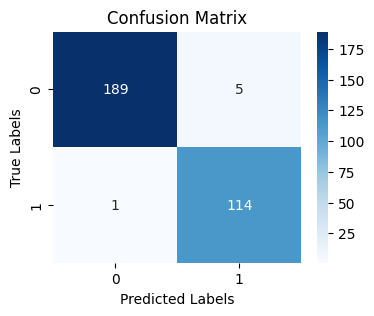

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=classifier.classes_,
            yticklabels=classifier.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

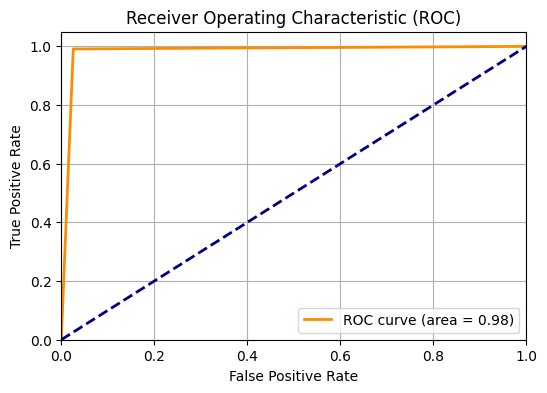

In [ ]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# Add grid lines
plt.grid()



plt.show()

In [ ]:
#applying SVM with rdf kernel
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, classification_report
from sklearn.svm import SVC

# Define a list of SVM classifiers with different kernels and parameters
svm_classifiers = [

    SVC(kernel='rbf', class_weight='balanced', random_state=42),

]

# Iterate over each SVM classifier and perform cross-validation
for svm_classifier in svm_classifiers:
    print("SVM Classifier (Kernel: {}):".format(svm_classifier.kernel))

    # Perform cross-validation
    num_folds = 5  # Number of folds for cross-validation
    scoring = make_scorer(accuracy_score)  # Scoring metric

    # Use cross_val_score to compute cross-validated accuracy scores
    cv_scores = cross_val_score(svm_classifier, X_train, y_train, cv=num_folds, scoring=scoring)

    # Print the accuracy scores for each fold
    print("Cross-validated accuracy scores:", cv_scores)
    print("Mean accuracy:", cv_scores.mean())

    # Fit the SVM classifier on the entire training set
    svm_classifier.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = svm_classifier.predict(X_test)

    # Evaluate the model's performance
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    print("-" * 50)  # Separating output for different SVM classifiers


SVM Classifier (Kernel: rbf):
Cross-validated accuracy scores: [0.96761134 0.96761134 0.98780488 0.97560976 0.95934959]
Mean accuracy: 0.9715973799414106
Accuracy: 0.9741100323624595
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98       194
           1       0.94      0.99      0.97       115

    accuracy                           0.97       309
   macro avg       0.97      0.98      0.97       309
weighted avg       0.98      0.97      0.97       309

--------------------------------------------------


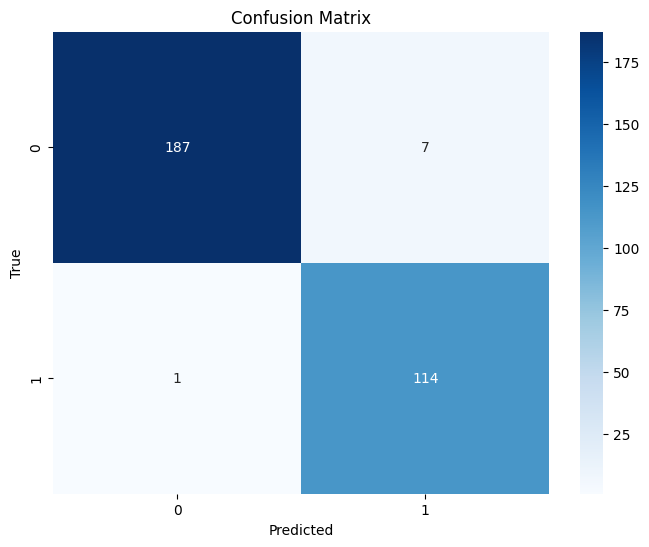

In [ ]:
# Create a confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=svm_classifier.classes_,
            yticklabels=svm_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()






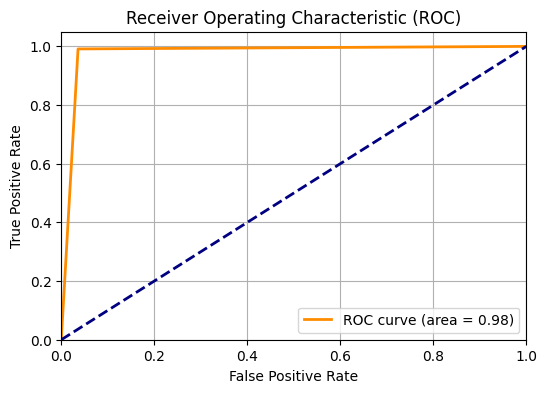

In [ ]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# Add grid lines
plt.grid()

plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# Building ANN model
model = Sequential()
model.add(Dense(128, input_shape=(X_combined.shape[1],), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=10, validation_data=(X_test, y_test))

# Evaluate the model
accuracy = model.evaluate(X_test, y_test)[1]
print("Test Accuracy:", accuracy)

Epoch 1/5
124/124 [==============================] - 4s 5ms/step - loss: 0.1817 - accuracy: 0.9489 - val_loss: 0.0625 - val_accuracy: 0.9741
Epoch 2/5
124/124 [==============================] - 0s 4ms/step - loss: 0.0441 - accuracy: 0.9797 - val_loss: 0.0522 - val_accuracy: 0.9773
Epoch 3/5
124/124 [==============================] - 0s 4ms/step - loss: 0.0200 - accuracy: 0.9943 - val_loss: 0.0296 - val_accuracy: 0.9968
Epoch 4/5
124/124 [==============================] - 0s 4ms/step - loss: 0.0079 - accuracy: 0.9984 - val_loss: 0.0267 - val_accuracy: 0.9968
Epoch 5/5
10/10 [==============================] - 0s 3ms/step - loss: 0.0231 - accuracy: 0.9935
Test Accuracy: 0.9935275316238403


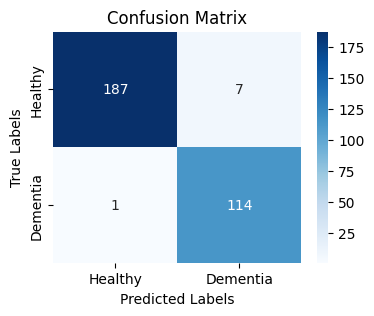

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Dementia"], yticklabels=["Healthy", "Dementia"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

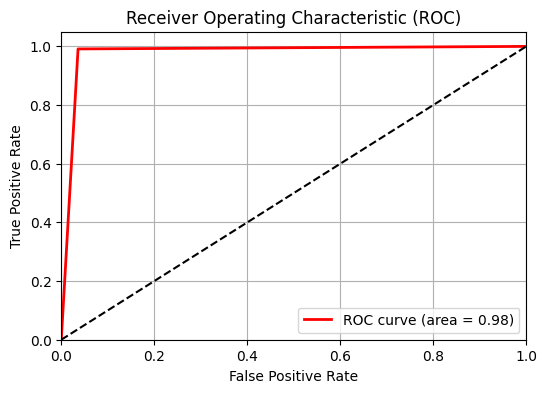

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curve and ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)  # y_pred_proba: predicted probabilities

# Get false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
# Add grid lines
plt.grid()
plt.show()

In [ ]:
#K-NN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Create the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# Perform cross-validation and get the accuracy scores for each fold
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=5)  # 5-fold cross-validation

# Print the accuracy scores for each fold
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

# Now, let's fit the model to the entire training set
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print("K-Nearest Neighbors (KNN) Results:")
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Cross-Validation Scores: [0.98380567 0.98380567 0.99593496 0.99186992 0.98780488]
Mean Accuracy: 0.9886442184259898
K-Nearest Neighbors (KNN) Results:
Accuracy: 0.9870550161812298
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       194
           1       0.97      0.99      0.98       115

    accuracy                           0.99       309
   macro avg       0.98      0.99      0.99       309
weighted avg       0.99      0.99      0.99       309



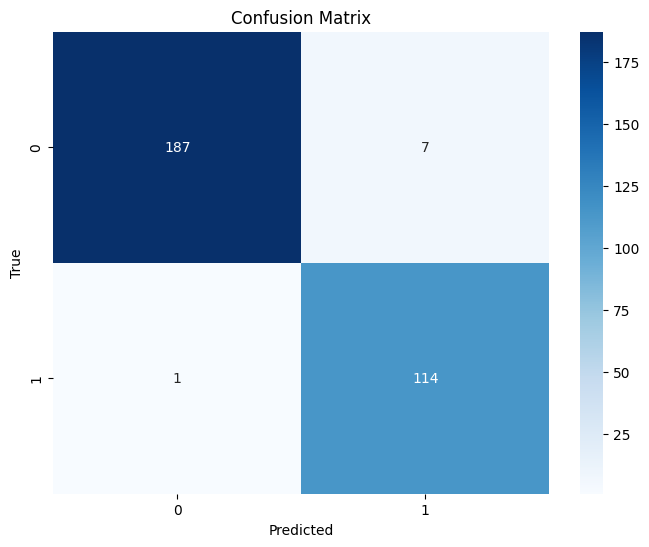

In [ ]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=knn_model.classes_,
            yticklabels=knn_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

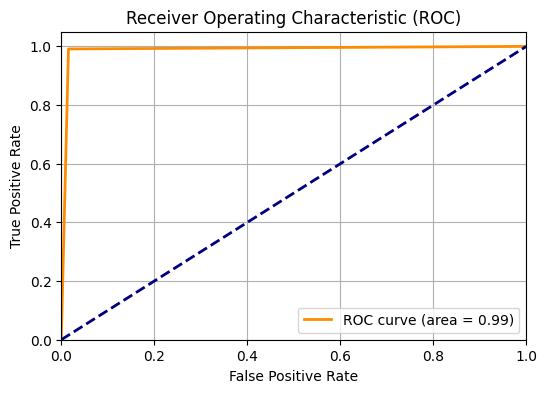

In [ ]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# Add grid lines
plt.grid()
plt.show()

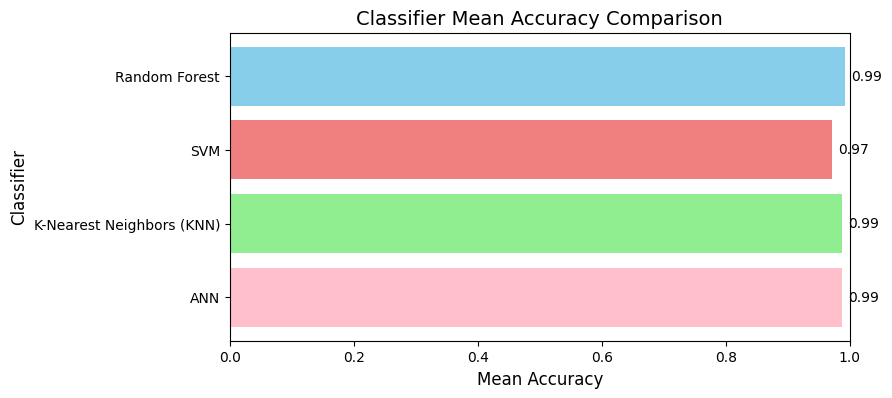

In [ ]:
# Create a list of classifiers
classifiers = [
    ("Random Forest", RandomForestClassifier(class_weight='balanced', random_state=42)),
    ("SVM", SVC(kernel='rbf', class_weight='balanced', random_state=42)),
    ("K-Nearest Neighbors (KNN)", KNeighborsClassifier(n_neighbors=5)),
]

# Create a list of unique colors for bars
colors = ['skyblue', 'lightcoral', 'lightgreen', 'pink']



# Create empty lists to store classifier names and accuracies
classifier_names = []
accuracies = []

# Perform cross-validation for each classifier and store accuracy scores
for name, classifier in classifiers:
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=5)
    mean_accuracy = cv_scores.mean()

    classifier_names.append(name)
    accuracies.append(mean_accuracy)


# Append ANN classifier name and accuracy to the lists
classifier_names.append("ANN")
accuracies.append(accuracy)

# Create a horizontal bar chart to visualize accuracies with different colors
plt.figure(figsize=(8, 4))
bars = plt.barh(classifier_names, accuracies, color=colors)
# Set the x-axis label to 'Mean Accuracy' and customize the y-axis label
plt.xlabel('Mean Accuracy', fontsize=12)
plt.ylabel('Classifier', fontsize=12)

# Set the title and adjust the font size
plt.title('Classifier Mean Accuracy Comparison', fontsize=14)

# Set the x-axis limit to match the accuracy range (0-1)
plt.xlim(0, 1)

# Invert the y-axis to display the highest accuracy at the top
plt.gca().invert_yaxis()

# Add text labels for each bar
for bar, accuracy in zip(bars, accuracies):
    plt.text(accuracy + 0.01, bar.get_y() + bar.get_height() / 2, f'{accuracy:.2f}', va='center', fontsize=10)

# Display the plot
plt.show()